In [103]:
import numpy as np
import scipy.stats as s
import configparser
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
from itertools import groupby
import pickle
from collections import namedtuple, defaultdict
from scipy import stats

import re

from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/marat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [119]:
d1 = pd.read_csv('target/test_predict_457k_243k_balanced_0_0_T_20171128T174840.tsv', sep='\t', na_values='None')
d2 = pd.read_csv('target/test_predict_243k_balanced_2911_0_20171129T120941.tsv', sep='\t', na_values='None')

data = pd.concat([d1, d2])


In [120]:
def plot_beta(bot, bestbot, title='', legend=True):
    neg, pos = bot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'r-', lw=5, alpha=0.6, label=label)

    neg, pos = bestbot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bestbot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'g-', lw=5, alpha=0.6, label=label)
          
    ztest = sm.stats.proportions_ztest([bot[1], bestbot[1]], [sum(bot), sum(bestbot)], alternative='two-sided')
    plt.title('{} (Fisher test z={:.3f}, pvalue={:.4f})'.format(title, *ztest))
    if legend:
        plt.legend()
    plt.xlim(0, 1)


In [127]:
def compare(data, eps=1e-2):
    res = {}
    for g, d in data.groupby(['operator', 'is_meaningful']):
        x = d['answer'].apply(lambda x: len(word_tokenize(x)))
#         res[g] = (x < 15).sum()
        res[g] = len(d)

    bot = [res.get(('bot', 0), eps), res.get(('bot', 1), eps)]
    bestbot = [res.get(('botbest', 0), eps), res.get(('botbest', 1), eps)]

    chi = s.chisquare(bot, f_exp=bestbot)
    ztest = sm.stats.proportions_ztest([bot[1], bestbot[1]], [sum(bot), sum(bestbot)], alternative='two-sided')
    
    return [chi.pvalue, ztest], [bot, bestbot], bestbot[1] / (bestbot[0] + bestbot[1]), bot[1] / (bot[1] + bot[0])

Index(['answer', 'chat_id', 'context', 'discriminator_score', 'is_meaningful',
       'operator', 'question', 'question_id', 'time_answered', 'time_asked',
       'user'],
      dtype='object')
overall 542 ([0.0002535471747481295, (1.0994539536652863, 0.27157010811266824)], [[146, 150], [133, 113]], 0.45934959349593496, 0.5067567567567568)


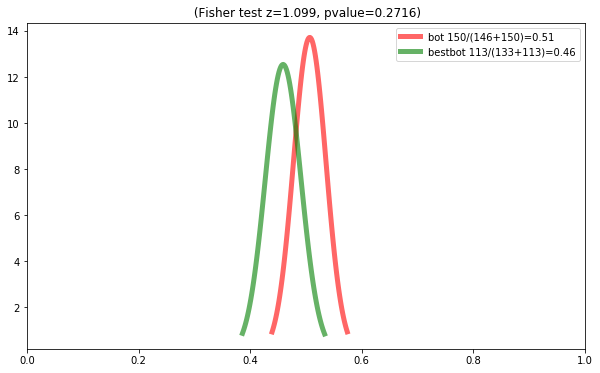

In [128]:
print(data.columns)

c = compare(data)
print('overall', len(data), c)

_, [bot, bestbot], *_2 = c
plot_beta(bot, bestbot)
plt.show()

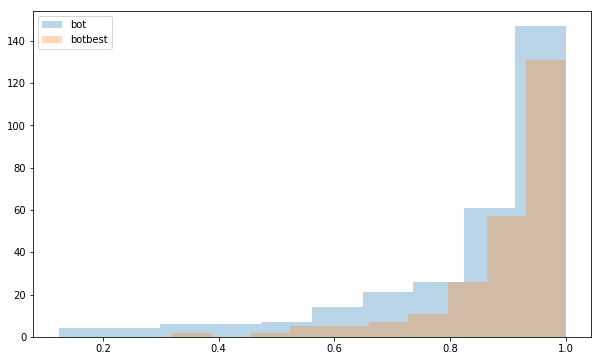

In [132]:
plt.hist(data[data['operator'] == 'bot']['discriminator_score'], label='bot', alpha=0.3)
plt.hist(data[data['operator'] == 'botbest']['discriminator_score'], label='botbest', alpha=0.3)
plt.legend()
plt.show()

In [76]:
from run_bot_2_variants import Row, prepare_dataset
dataset = prepare_dataset('downloads/sber3.csv')


with open('downloads/sber3.csv2var.pickle', 'rb') as f:
    rows = pickle.load(f)
rows_list = list(rows.values())

In [56]:
row = rows_list[8]
row

Row(id=105032, question='списание идет автооматически .  ', answer='Вы хотите распечатать входящее платежное поручение ? Или оплата пополнения счета от физических лиц ?', operator='botbest', discriminator='0.4480302929878235')

In [33]:
by_question = defaultdict(list)
for context, rs in dataset.items():
    by_question[rs[0].question].extend(rs)

In [59]:
for row in rows_list:
    if row.operator == 'bot':
        continue
    
    if len(by_question[row.question]) > 50:
        continue
        
    assert float(row.discriminator) == max(by_question[row.question], key=lambda x: float(x.discriminator)).discriminator
# row.discriminator, max(by_question[row.question], key=lambda x: float(x.discriminator)).discriminator


AssertionError: 

In [60]:
len(by_question[row.question])

36